In [589]:
import os
import logging
import zipfile
import glob

import numpy as np
import matplotlib  # for cmaps
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [590]:
on_local = os.path.isdir('/Users/user/')
if on_local:
    base_dir = '/Users/user/repos/zoobot-3d/'
else:
    base_dir = '/share/nas2/walml/galaxy_zoo/segmentation/'

df = pd.read_parquet(base_dir + 'data/test_catalog.parquet')
logging.info(df['spiral_mask_loc'].iloc[0])
df['spiral_mask_exists'] = df['spiral_mask_loc'].apply(os.path.isfile)
df['bar_mask_exists'] = df['bar_mask_loc'].apply(os.path.isfile)
assert any(df['spiral_mask_exists'])
df = df[df['spiral_mask_exists'] | df['bar_mask_exists']].reset_index(drop=True)

In [591]:
is_predicted_feat = df['smooth-or-featured_featured-or-disk_fraction'] > 0.5
is_predicted_face = df['disk-edge-on_yes_fraction'] < 0.5
is_predicted_spiral = df['has-spiral-arms_yes_fraction'] > 0.5
df = df[is_predicted_feat & is_predicted_face & is_predicted_spiral].reset_index(drop=True)

In [592]:
# extract any previous results from sparcfire

zip_files = glob.glob(base_dir + 'data/sparcfire/results/test_images/galaxy_*.zip')
assert zip_files, 'No zip files found'
for path_to_zip_file in zip_files:
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(base_dir + 'data/sparcfire/results/test_images_unzipped')

In [593]:
df['sparcfire_jpg_loc'] = df['desi_jpg_loc'].apply(lambda x: base_dir + 'data/sparcfire/test_images/' + x.split('/')[-1])
df['sparcfire_jpg_loc'].iloc[0]

'/Users/user/repos/zoobot-3d/data/sparcfire/test_images/374395_3484.jpg'

In [594]:
df['sparcfire_mask_loc'] = df.apply(
    lambda x: base_dir + f'data/sparcfire/results/test_images_unzipped/{x["dr8_id"]}-H_clusMask-merged.png', axis=1)
df['sparcfire_mask_loc'].iloc[0]

'/Users/user/repos/zoobot-3d/data/sparcfire/results/test_images_unzipped/374395_3484-H_clusMask-merged.png'

In [595]:
checkpoint_path = base_dir + 'outputs/run_1695899881.3925836/epoch=93-step=1880.ckpt'
# checkpoint_path = base_dir + 'outputs/run_1695938854.2480044/epoch=91-step=1840.ckpt'

save_dir = os.path.dirname(checkpoint_path) + '/predictions/'
df['zoobot_spiral_mask_loc'] = df['dr8_id'].apply(lambda x: save_dir + f'/{x}_spiral_pred_viz.png')
df['zoobot_bar_mask_loc'] = df['dr8_id'].apply(lambda x: save_dir + f'/{x}_bar_pred_viz.png')

df['zoobot_spiral_mask_loc'].iloc[0]

'/Users/user/repos/zoobot-3d/outputs/run_1695899881.3925836/predictions//374395_3484_spiral_pred_viz.png'

In [596]:
# example = df.query('dr8_id == "501100_316"').squeeze()

In [597]:
example = df.iloc[1]

In [598]:
def center_crop(im, new_width):
    new_height = new_width

    width, height = im.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    return im.crop((left, top, right, bottom))

In [599]:
def create_example_grid(galaxy, size_per_im=224):

    # galaxy im is 424
    # vol will align with this, so just edit consistently
    # to edit for sparcfire-like, crop to 256 then resize
    galaxy_im = center_crop(Image.open(galaxy['desi_jpg_loc']), 256).resize((size_per_im, size_per_im))
    vol_spiral_mask = center_crop(Image.open(galaxy['spiral_mask_loc']), 256).resize((size_per_im, size_per_im))
    # 
    # vol_bar_mask = Image.open(galaxy['bar_mask_loc']).resize((size_per_im, size_per_im))

    # sparcfire im is 424, cropped to 256
    # simply resize to 224
    # sparcfire_im = Image.open(galaxy['sparcfire_jpg_loc']).resize((size_per_im, size_per_im))
    sparcfire_im = galaxy_im
    sparcfire_mask = Image.open(galaxy['sparcfire_mask_loc']).resize((size_per_im, size_per_im))
    # convert to binary mask
    sparcfire_mask = Image.fromarray((np.array(sparcfire_mask) > 0).any(axis=2).astype(np.uint8)*255)

    # zoobot was cropped to 275.6, predictions made at 275.6 FoV but already resized to 224
     # need to crop to 256 equiv (so resize and then crop), then final resize
    zoobot_spiral_mask = Image.open(galaxy['zoobot_spiral_mask_loc']) 
    # zoobot_spiral_mask = center_crop(zoobot_spiral_mask.resize((310, 310)), 256).resize((size_per_im, size_per_im)
    zoobot_spiral_mask = center_crop(zoobot_spiral_mask, 175).resize((size_per_im, size_per_im))
    # .resize((276, 276)).crop((left, upper, right, lower))

    # galaxy, mask, overlaid galaxy/mask
    fig, rows = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))

    cmap = matplotlib.colormaps['Purples']
    ax0, ax1, ax2 = rows[0]
    ax0.imshow(sparcfire_im)
    ax1.imshow(sparcfire_mask, cmap=cmap)
    ax2.imshow(sparcfire_im)
    ax2.imshow(sparcfire_mask, cmap=cmap, alpha=0.5)
    
    ax0, ax1, ax2 = rows[1]
    ax0.imshow(galaxy_im)
    ax1.imshow(vol_spiral_mask, cmap=cmap)
    ax2.imshow(galaxy_im)
    ax2.imshow(vol_spiral_mask, cmap=cmap, alpha=0.5)

    ax0, ax1, ax2 = rows[2]
    ax0.imshow(galaxy_im)
    ax1.imshow(zoobot_spiral_mask, cmap=cmap)
    ax2.imshow(galaxy_im)
    ax2.imshow(zoobot_spiral_mask, cmap=cmap, alpha=0.5)
            #    np.where(np.array(zoobot_spiral_mask) > 10, 0.5, 0))

    [ax.axis('off') for row in rows for ax in row]

    fig.tight_layout()

    return fig


def save_example_grid(galaxy, save_dir, size_per_im=224):
    save_loc = save_dir + f'v2/{galaxy["dr8_id"]}_comparison_grid_spiral_v2.jpg'
    if not os.path.isfile(save_loc):
        fig = create_example_grid(galaxy, size_per_im)
        fig.savefig(save_loc, dpi=300)
    

In [609]:
def create_example_bar_grid(galaxy, size_per_im=224):

    # galaxy im is 424
    # vol will align with this, so just edit consistently
    # to edit for sparcfire-like, crop to 256 then resize
    galaxy_im = center_crop(Image.open(galaxy['desi_jpg_loc']), 256).resize((size_per_im, size_per_im))
    vol_bar_mask = center_crop(Image.open(galaxy['bar_mask_loc']), 256).resize((size_per_im, size_per_im))

    zoobot_bar_mask = Image.open(galaxy['zoobot_bar_mask_loc']) 
    zoobot_bar_mask = center_crop(zoobot_bar_mask, 175).resize((size_per_im, size_per_im))

    # galaxy, mask, overlaid galaxy/mask
    fig, rows = plt.subplots(nrows=2, ncols=3, figsize=(5, 5*2/3))

    cmap = matplotlib.colormaps['Purples']

    ax0, ax1, ax2 = rows[0]
    ax0.imshow(galaxy_im)
    ax1.imshow(vol_bar_mask, cmap=cmap)
    ax2.imshow(galaxy_im)
    ax2.imshow(vol_bar_mask, cmap=cmap, alpha=0.5)

    ax0, ax1, ax2 = rows[1]
    ax0.imshow(galaxy_im)
    ax1.imshow(zoobot_bar_mask, cmap=cmap)
    ax2.imshow(galaxy_im)
    ax2.imshow(zoobot_bar_mask, cmap=cmap, alpha=0.5)

    [ax.axis('off') for row in rows for ax in row]

    fig.tight_layout()

    return fig


def save_example_bar_grid(galaxy, save_dir, size_per_im=224):
    save_loc = save_dir + f'v2/{galaxy["dr8_id"]}_comparison_grid_bar_v2.jpg'
    if not os.path.isfile(save_loc):
        fig = create_example_bar_grid(galaxy, size_per_im)
        fig.savefig(save_loc, dpi=300)

In [610]:
df['has_sparcfire_result'] = df['sparcfire_mask_loc'].apply(os.path.isfile)
df['has_sparcfire_result'].sum()

101

In [611]:
df = df.query('has_sparcfire_result')

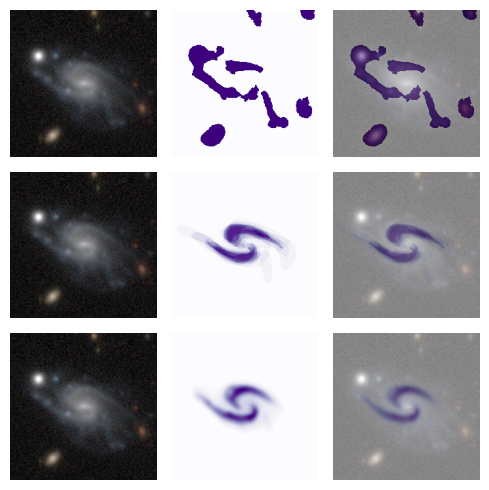

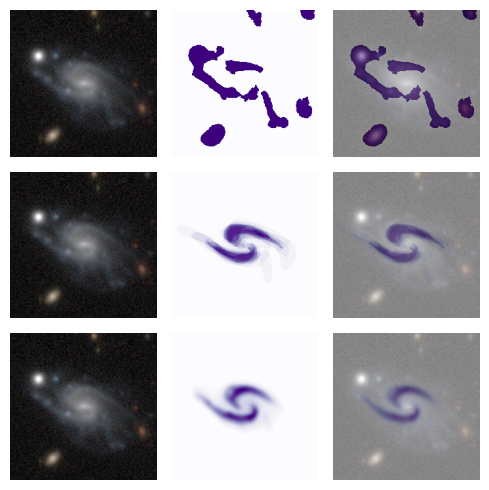

In [612]:
create_example_grid(example)

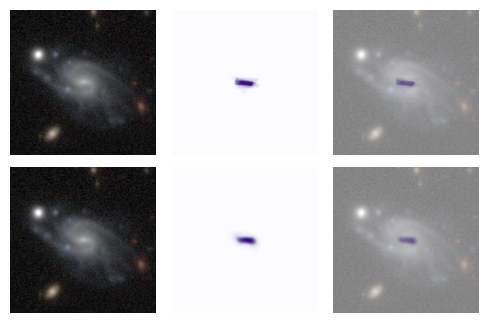

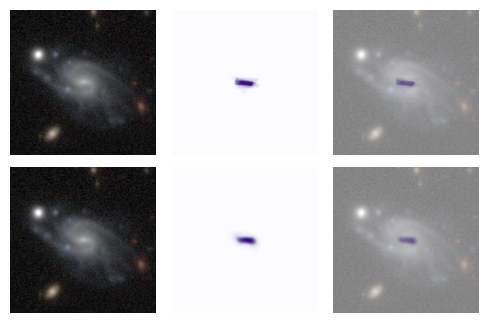

In [614]:
create_example_bar_grid(example)

In [615]:
for _, galaxy in df.query('spiral_mask_exists').iterrows():
    save_example_grid(galaxy, save_dir=base_dir + 'data/comparison_grids/')
    plt.close('all')

In [616]:
for _, galaxy in df.query('bar_mask_exists').iterrows():
    save_example_bar_grid(galaxy, save_dir=base_dir + 'data/comparison_grids/')
    plt.close('all')